In [8]:
## decision tree classifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import model_selection

In [2]:
X_train = np.load('../data/X_train.npy', allow_pickle = True)
X_test = np.load('../data/X_test.npy', allow_pickle = True)
y_train = np.load('../data/y_train.npy', allow_pickle = True)
y_test = np.load('../data/y_test.npy', allow_pickle = True)
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of Y_train: ", y_train.shape)
print("shape of Y_test: ", y_test.shape)

shape of X_train:  (122289, 1044)
shape of X_test:  (60232, 1044)
shape of Y_train:  (122289, 5)
shape of Y_test:  (60232, 5)


In [3]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_test, y_test = sm.fit_resample(X_test, y_test)

Autoselected model

https://neptune.ai/blog/hyperparameter-tuning-in-python-complete-guide

In [18]:
params = {
    'max_depth': [5,8, 10, 20,40],
    'min_samples_leaf': [5, 10, 20, 30,40],
    'criterion': ["gini", "entropy"]
}
model = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=model, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [19]:
%%time
grid_search.fit(X_train[:50000], y_train[:50000])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Wall time: 2min 44s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 10, 20, 40],
                         'min_samples_leaf': [5, 10, 20, 30, 40]},
             scoring='accuracy', verbose=1)

In [22]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.sort_values(by=['rank_test_score'], ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,10.492500,0.524642,0.115462,0.007410,gini,10,20,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.6648,0.6604,0.6598,0.6680,0.6636,0.66332,0.003003,1
13,10.763529,0.376515,0.121352,0.020913,gini,10,30,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.6660,0.6620,0.6564,0.6638,0.6617,0.66198,0.003184,2
7,10.509985,1.906014,0.119948,0.013527,gini,8,20,"{'criterion': 'gini', 'max_depth': 8, 'min_sam...",0.6655,0.6586,0.6593,0.6569,0.6670,0.66146,0.004016,3
8,11.135435,1.006035,0.325234,0.161166,gini,8,30,"{'criterion': 'gini', 'max_depth': 8, 'min_sam...",0.6675,0.6603,0.6566,0.6563,0.6637,0.66088,0.004276,4
37,10.495607,0.283553,0.120550,0.004056,entropy,10,20,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.6654,0.6543,0.6559,0.6629,0.6594,0.65958,0.004156,5


Train model

In [4]:
## decision tree
dtree = DecisionTreeClassifier(random_state=42, max_depth=10,min_samples_leaf=20)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, random_state=42)

In [7]:
filename = 'decision_tree.sav'
pickle.dump(dtree, open(filename, 'wb'))

In [5]:
predictions = dtree.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.6938739953914461
              precision    recall  f1-score   support

           0       0.66      0.56      0.61     35586
           1       0.82      0.86      0.84     35586
           2       0.91      0.91      0.91     35586
           3       0.68      0.82      0.74     35586
           4       0.67      0.31      0.42     35586

   micro avg       0.76      0.69      0.72    177930
   macro avg       0.75      0.69      0.70    177930
weighted avg       0.75      0.69      0.70    177930
 samples avg       0.69      0.69      0.69    177930



c:\Users\bobmst\.conda\envs\ds310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average = 'weighted',zero_division = 0),
           'recall' : make_scorer(recall_score, average = 'weighted',zero_division = 0), 
           'f1_score' : make_scorer(f1_score, average = 'weighted',zero_division = 0)}
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_validate(estimator=dtree,
                                          X=X_test,
                                          y=y_test,
                                          cv=kfold,
                                          scoring=scoring)
results

{'fit_time': array([8.19203663, 8.56456161, 8.64304018, 8.15782452, 8.42657685,
        8.92793298, 8.56718326, 8.44134974, 8.07654381, 8.05405092]),
 'score_time': array([0.06563544, 0.0658741 , 0.0634346 , 0.05611467, 0.08017349,
        0.07025814, 0.05034542, 0.05988383, 0.06095409, 0.06345296]),
 'test_accuracy': array([0.43809363, 0.43247344, 0.44776036, 0.50581689, 0.71988984,
        0.73478334, 0.88585399, 0.90805373, 0.72118249, 0.2515034 ]),
 'test_precision': array([0.63430481, 0.63231102, 0.63068254, 0.75816173, 0.94165642,
        1.        , 0.99712112, 1.        , 0.97431726, 1.        ]),
 'test_recall': array([0.43809363, 0.43247344, 0.44776036, 0.50581689, 0.71988984,
        0.73478334, 0.88585399, 0.90805373, 0.72118249, 0.2515034 ]),
 'test_f1_score': array([0.46101248, 0.45356178, 0.46736551, 0.58503246, 0.80132891,
        0.84711828, 0.93783289, 0.95181149, 0.82278227, 0.40192204])}

In [16]:
print('Accuracy: %.3f (%.3f)' % (np.mean(results['test_accuracy']), np.std(results['test_accuracy'])))
print('Precision: %.3f (%.3f)' % (np.mean(results['test_precision']), np.std(results['test_precision'])))
print('Recall: %.3f (%.3f)' % (np.mean(results['test_recall']), np.std(results['test_recall'])))
print('F1_score: %.3f (%.3f)' % (np.mean(results['test_f1_score']), np.std(results['test_f1_score'])))

Accuracy: 0.605 (0.208)
Precision: 0.857 (0.162)
Recall: 0.605 (0.208)
F1_score: 0.673 (0.208)


In [30]:
# Confusion Matrix
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
matrix

array([[24324,  2318,  1833,  3359,  3752],
       [ 4342, 30556,    88,   322,   278],
       [ 1282,   130, 32441,  1659,    74],
       [ 3299,  1496,    14, 29354,  1423],
       [11864,  2876,  1158,  8659, 11029]], dtype=int64)

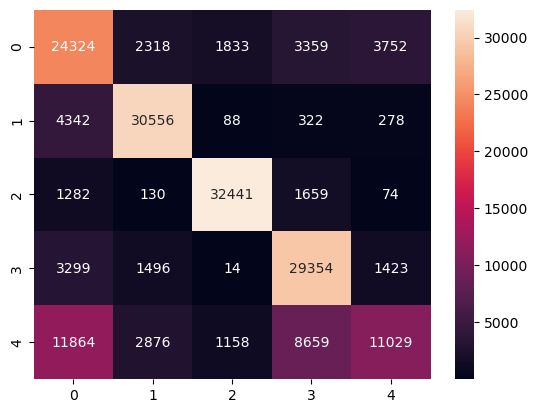

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(matrix, annot = True, fmt = 'd')
plt.show()